# Forest Cover Classification

### **By Vinesh Raghvani**

In this project, I will be using deep learning to forecast forest cover type (the most prevalent form of tree cover) using just cartographic data. The actual forest cover type for a specific 30 × 30 meter cell was identified using US Forest Service (USFS) Region 2 Resource Information System data. The cover types are as follows:

1. Spruce/Fir
1. Lodgepole Pine
1. Ponderosa Pine
1. Cottonwood/Willow
1. Aspen
1. Douglas-fir
1. Krummholz

### Importing Libraries

In [41]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [42]:
# Disable those annoying warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

### Defining a function to sort and prepare the data for usage 

In [43]:
def prep_data(raw_df):
    """
    Prepare data that can be readily consumed by ML/DL algorithms.
    - separate features from class variables
    - split into training and testing dataset
    - scale numerical data
    
    param: a dataframe of input data
    output: X_train_normalized, X_test_normalized, y_train, y_test
    """
    raw_data = raw_df.values
    X, y = raw_data[:, :-1], raw_data[:, -1]

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    # normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, X_test_normalized, y_train, y_test

### Defining a Build Model function 

In [44]:
def build_model(num_features):
    """
    Build the model architecture (and compile it).
    input: number of features
    output: Keras model object.
    """
    classifier = keras.Sequential()
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(32, activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(8, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

### Defining a Confusion Matrix and Heatmap function

In [45]:
def plot_heatmap(class_names, y_pred, y_test):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'confusion_matrix.png')

### Defining a funtion to check the performance of the Model

In [46]:
def plot_history(history, param):
    """
    Shows how the model performs (in terms of accuracy and loss) over several epochs.
    """
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

### Defining a main() function below which will prepare the dataset, builds the model, evaluates the model and gives predictions. Then we will plot the performance metrics.

In [47]:
def main():
    infile = 'cover_data.csv'
    raw_df = pd.read_csv(infile)

    # EDA
    # Uncomment the below two lines to run EDA. Takes > 10 min to run.
    #my_report = sv.analyze(raw_df)
    #my_report.show_html()

    cols = raw_df.columns.tolist()
    features, label = cols[:-1], cols[-1]
    X_train, X_test, y_train, y_test = prep_data(raw_df)

    # Build a DL model
    num_features = len(features)
    model = build_model(num_features)

    print("Summary report of Keras classifier:")
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)

Summary report of Keras classifier:


c:\Users\dexte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,864 (22.91 KB)

 Trainable params: 5,864 (22.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5898 - loss: 1.0677 - val_accuracy: 0.7426 - val_loss: 0.6104
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7490 - loss: 0.5919 - val_accuracy: 0.7621 - val_loss: 0.5536
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7686 - loss: 0.5457 - val_accuracy: 0.7776 - val_loss: 0.5238
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7816 - loss: 0.5183 - val_accuracy: 0.7862 - val_loss: 0.5032
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7895 - loss: 0.4974 - val_accuracy: 0.7966 - val_loss: 0.4847
Epoch 6/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7964 - loss: 0.4811 - val_accuracy: 0.8010 - val_loss: 0.4720
Epoch 7/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8027 - loss: 0.4664 - val_accuracy: 0.8056 - val_loss: 0.4624
Epoch 8/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8089 - loss: 0.4552 - val_accu

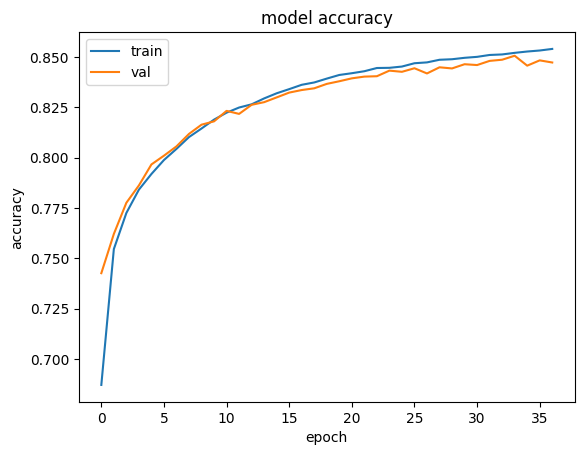

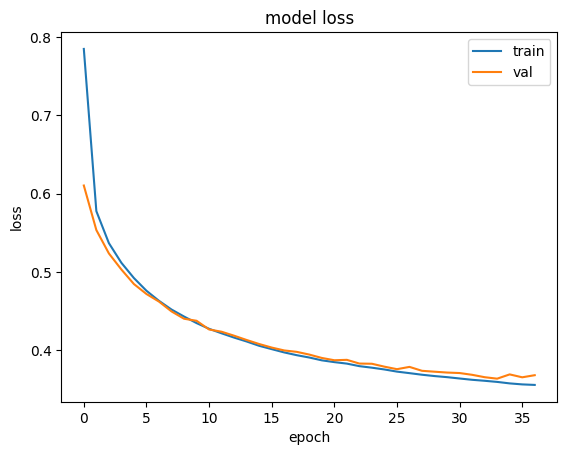

Test loss: 0.3669833242893219
Test accuracy: 0.8479127287864685
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 2s 418us/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.85      0.84      0.85     42368
   Lodgepole Pine       0.87      0.88      0.87     56661
   Ponderosa Pine       0.78      0.88      0.83      7151
Cottonwood/Willow       0.82      0.69      0.75       549
            Aspen       0.74      0.45      0.56      1899
      Douglas-fir       0.70      0.58      0.64      3473
        Krummholz       0.86      0.88      0.87      4102

         accuracy                           0.85    116203
        macro avg       0.80      0.74      0.77    116203
     weighted avg       0.85      0.85      0.85    116203



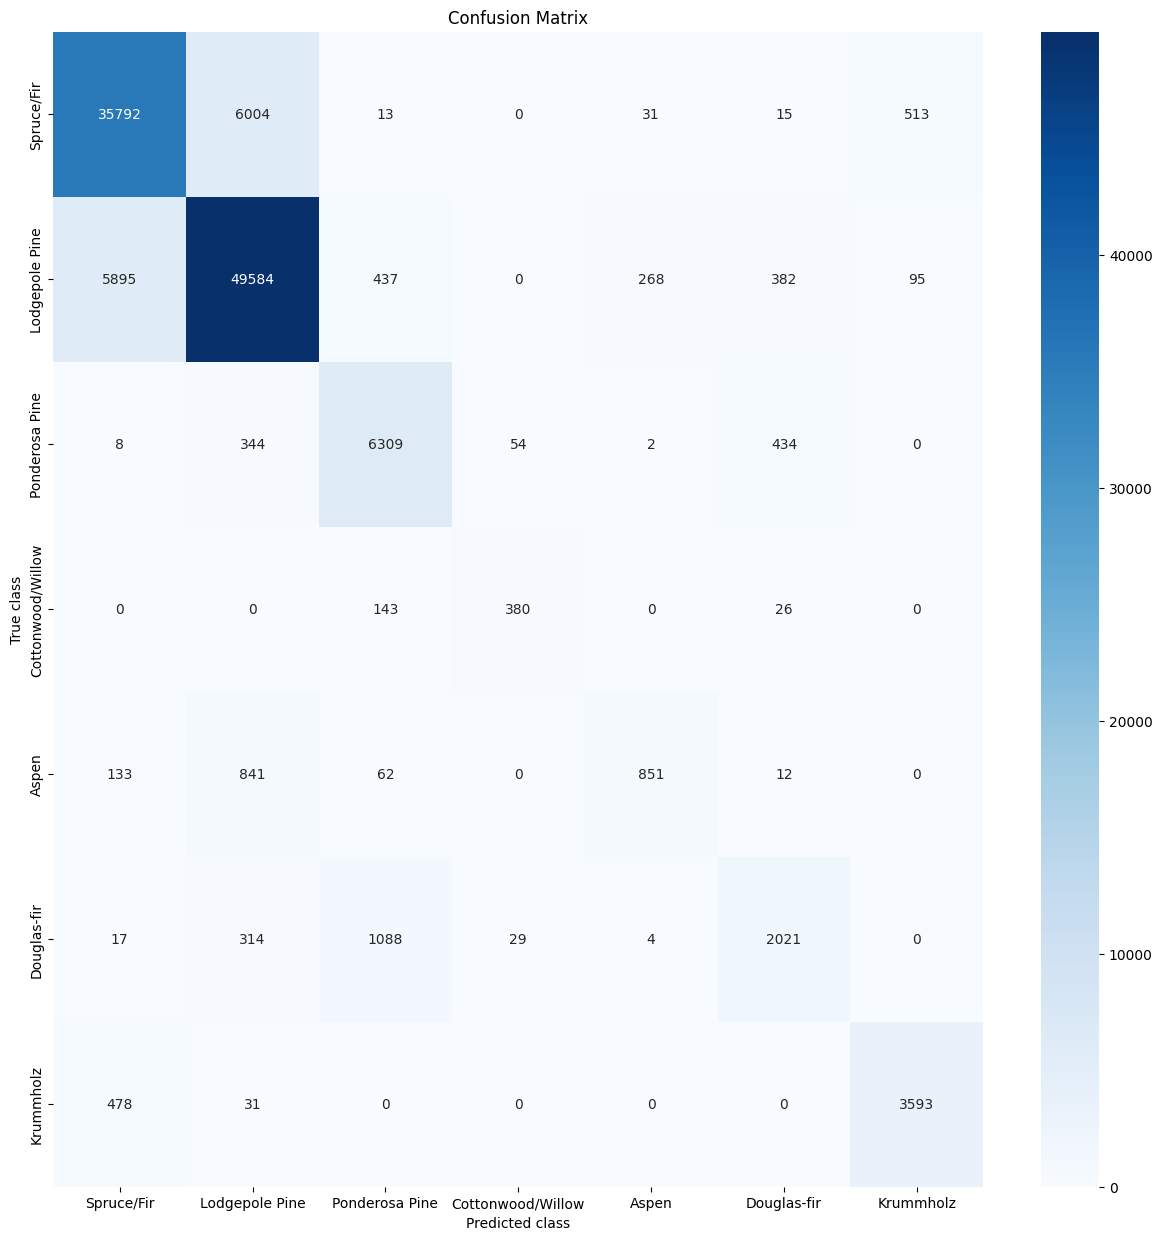

In [49]:
if __name__ == '__main__':
    main()

## Conclusion:

The heatmap's diagonal numbers indicate the amount of successfully identified cases. Every other number displays incorrect classifications on both sides of the diagonal. Aspen, Douglas-fir, Lodgepole Pine, and Cottonwood Willow are among the species with the highest percentage of misclassifications. The following can be looked at in order to determine the potential causes:

1. Verify the percentage of observations for every kind of cover. The classification process will be impacted by dataset imbalances.
1. The layout of every wilderness area.
1. Look for commonalities between various cover kinds (scatter plots, correlation, etc.). The model may be tripping-up because of these commonalities, among other reasons. One method to deal with it is to meticulously eliminate every collinear variable until there is just one.
1. Carefully work with domain experts to eliminate errors, inconsistent data, and noise from training sets.
1. Consider using a different performance metric than "accuracy." When the data is unbalanced, the measure becomes unreliable. For this reason, we also have other metrics like F1-score, Precision/Recall, etc.
1. Consider resampling the data using a stratified or properly under- or oversampled sample. Thresholding could be used for downsampling.

The most crucial point to note here is that weight updates in deep learning are determined by the gradient(s) of the majority class(es), which dominate the space. Additionally, there are some cutting-edge methods that will improve this circumstance.